# AMLS final project

This notebook contains the work for the ELEC0134 Applied Machine Learning Systems class at UCL. The solution is implemented in Keras.

## Using Drive with Colab, typical imports

In [0]:
# Set up Google Drive for use with Colaboratory
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

# Magic calls TensorFlow 2.0 when importing
%tensorflow_version 2.x
import tensorflow as tf

# This tests whether a GPU is running
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

# Import Keras
from tensorflow import keras

# Check version of TensorFlow and Keras
print(tf.__version__)
print(keras.__version__)

TensorFlow 2.x selected.
Found GPU at: /device:GPU:0
2.1.0-rc1
2.2.4-tf


## Changing directory, sanity checks

In [0]:
root_dir = "/content/drive/My Drive/"
change_dir = root_dir + "dataset_AMLS_19-20/celeba"

os.chdir(change_dir)

In [0]:
# Check current directory
!pwd

/content/drive/My Drive/dataset_AMLS_19-20/celeba


In [0]:
# List contents of directory
!ls

img  labels.csv


## Creating data input pipeline

In [0]:
# Import data as dataframe, drop unnecessary column
df = pd.read_csv("labels.csv", sep="\t", dtype=str)

# Create separate dataframes for gender and smiling
gender = df.copy()
smiling = df.copy()

gender.drop(gender.columns[0], axis=1, inplace=True)
gender.drop(gender.columns[2], axis=1, inplace=True)

smiling.drop(smiling.columns[0], axis=1, inplace=True)
smiling.drop(smiling.columns[1], axis=1, inplace=True)

In [0]:
# Inspect data
df.head()

,Unnamed: 0,img_name,gender,smiling
0,0,0.jpg,-1,1
1,1,1.jpg,-1,1
2,2,2.jpg,1,-1
3,3,3.jpg,-1,-1
4,4,4.jpg,-1,-1


In [0]:
gender.head()

,img_name,gender
0,0.jpg,-1
1,1.jpg,-1
2,2.jpg,1
3,3.jpg,-1
4,4.jpg,-1


In [0]:
len(gender)

5000

In [0]:
smiling.head()

,img_name,smiling
0,0.jpg,1
1,1.jpg,1
2,2.jpg,-1
3,3.jpg,-1
4,4.jpg,-1


In [0]:
i
smiling_train, smiling_test = train_test_split(
    smiling, 
    test_size=0.2, 
    random_state=42
    )

In [0]:
gender_train.head()

,img_name,gender
4227,4227.jpg,-1
4676,4676.jpg,1
800,800.jpg,1
3671,3671.jpg,-1
4193,4193.jpg,-1


In [0]:
len(gender_train)

4000

In [0]:
gender_test.head()

,img_name,gender
1501,1501.jpg,-1
2586,2586.jpg,-1
2653,2653.jpg,-1
1055,1055.jpg,-1
705,705.jpg,1


In [0]:
smiling_train.head()

,img_name,smiling
4227,4227.jpg,1
4676,4676.jpg,1
800,800.jpg,-1
3671,3671.jpg,1
4193,4193.jpg,-1


In [0]:
# We check the average dimensions of the images in the dataset

# Code from
# https://towardsdatascience.com/image-classification-python-keras-tutorial-kaggle-challenge-45a6332a58b8

from PIL import Image

def get_size_statistics(DIR, number_of_files):
  heights = []
  widths = []
  counter = 1
  for img in os.listdir(DIR):
    path = os.path.join(DIR, img)
    print("Opening " + path + ": " + str(counter) + "/" + str(number_of_files))
    data = np.array(Image.open(path)) # PIL Image library
    heights.append(data.shape[0])
    widths.append(data.shape[1])
    counter += 1
  avg_height = sum(heights) / len(heights)
  avg_width = sum(widths) / len(widths)
  print('\n')
  print("Average Height: " + str(avg_height))
  print("Max Height: " + str(max(heights)))
  print("Min Height: " + str(min(heights)))
  print('\n')
  print("Average Width: " + str(avg_width))
  print("Max Width: " + str(max(widths)))
  print("Min Width: " + str(min(widths)))

get_size_statistics("img/", len(df))

In [0]:
# We now create two ImageDataGenerator objects for the gender dataset:
# one for training, the other for validation
from keras.preprocessing.image import ImageDataGenerator

# https://forums.fast.ai/t/split-data-using-fit-generator/4380/4
# for validation split

# We rescale to ensure RGB values fall between 0 and 1
# We set aside 20% of the training set for validation
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# We generate an image-label pair for the training set as follows
gender_train_gen = datagen.flow_from_dataframe(
    dataframe=gender_train, 
    directory="img/",
    x_col="img_name",
    y_col="gender",
    class_mode="sparse",
    target_size=(218,178),
    batch_size=32,
    subset="training"
    )

# We generate an image-label pair for the validation set as follows
gender_val_gen = datagen.flow_from_dataframe(
    dataframe=gender_train,
    directory="img/",
    x_col="img_name",
    y_col="gender",
    class_mode="sparse",
    target_size=(218,178),
    batch_size=32,
    subset="validation"
    )

Using TensorFlow backend.


Found 3200 validated image filenames belonging to 2 classes.
Found 800 validated image filenames belonging to 2 classes.


In [0]:
# We generate an image-label pair for the gender test set as follows
# We set batch_size = size of test set
gender_test_gen = datagen.flow_from_dataframe(
    dataframe=gender_test,
    directory="img/",
    x_col="img_name",
    y_col="gender",
    class_mode="sparse",
    target_size=(218,178),
    batch_size=1000
    )

Found 1000 validated image filenames belonging to 2 classes.


In [0]:
# Convert gender test generator into numpy arrays
# https://stackoverflow.com/questions/42284873/assign-imagedatagenerator-result-to-numpy-array
itr = gender_test_gen
gender_X_test, gender_y_test = itr.next()

In [0]:
# Create two ImageDataGenerator objects for the smiling dataset in a similar way

# https://forums.fast.ai/t/split-data-using-fit-generator/4380/4
# for validation split

# We rescale to ensure RGB values fall between 0 and 1
# We set aside 20% of the training set for validation
datagen = ImageDataGenerator(rescale=1./255,
                             validation_split=0.2)

# We generate an image-label pair for the training set as follows
smiling_train_gen = datagen.flow_from_dataframe(
    dataframe=smiling_train,
    directory="img/",
    x_col="img_name",
    y_col="smiling",
    class_mode="sparse",
    target_size=(218,178),
    batch_size=32,
    subset="training"
    )

# We generate an image-label pair for the validation set as follows
smiling_val_gen = datagen.flow_from_dataframe(
    dataframe=smiling_train,
    directory="img/",
    x_col="img_name",
    y_col="smiling",
    class_mode="sparse",
    target_size=(218,178),
    batch_size=32,
    subset="validation"
    )

Found 3200 validated image filenames belonging to 2 classes.
Found 800 validated image filenames belonging to 2 classes.


## Building and training the models



### Multi-layer Perceptron (MLP)

In [0]:
218*178*3

116412

In [0]:
import math

math.sqrt(218*178*3*2)

482 / 2

241.0

In [0]:
# Creating a classification MLP with two hidden layers
# We are using the Sequential API which creates a stack of layers
# in which the input flows through one after the other

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Instantiate Sequential API
mlp_model = keras.models.Sequential()

# This flattens the 218x178x3 input into a 1D tensor
mlp_model.add(keras.layers.Flatten(input_shape=(218,178,3)))

# This adds a fully connected layer with 300 neurons using the ReLU
# activation function
mlp_model.add(keras.layers.Dense(300, activation="relu"))

# This adds a fully connected layer with 100 neurons using the ReLU
# activation function
mlp_model.add(keras.layers.Dense(100, activation="relu"))

# This creates the output layer.
mlp_model.add(keras.layers.Dense(2, activation="softmax"))

In [0]:
32 / 482

0.06639004149377593

In [0]:
# We now compile the MLP model to specify the loss function
# and the optimizer to use (SGD)

mlp_model.compile(loss="sparse_categorical_crossentropy", # b/c of exclusive, sparse outputs
                  optimizer='sgd', # We use SGD to optimise the ANN
                  metrics=["accuracy"] # Used for classifiers
                  ) 

In [0]:
# Training and evaluating the MLP model on the gender dataset
mlp_gender_history = mlp_model.fit(
    gender_train_gen,
    steps_per_epoch=gender_train_gen.samples // 32,
    validation_data=gender_val_gen,
    validation_steps=gender_val_gen.samples // 32,
    epochs=30
    )

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 100 steps, validate for 25 steps
Epoch 1/30
 52/100 [==============>...............] - ETA: 9:44 - loss: 1.0763 - accuracy: 0.5240

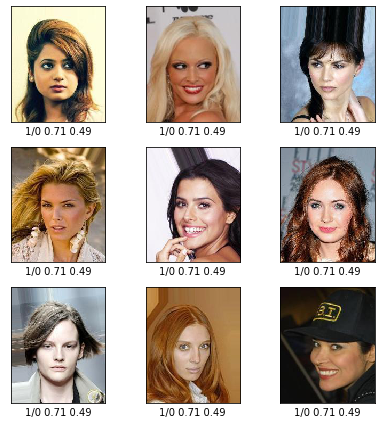

In [0]:
# Get indices of wrongfully misclassified test set
# https://stackoverflow.com/questions/39300880/how-to-find-wrong-prediction-cases-in-test-set-cnns-using-keras
def get_wrong_indices(X_test, y_test):
    incorrects = np.asarray(np.nonzero(mlp_model.predict_classes(X_test).reshape((-1,)) != y_test))
    incorrects = incorrects.T.flatten()
    return incorrects

# This returns an array which contains the predictions for the misclassified images
def get_incorrect_preds(X_test, y_test, incorrects):
    incorrect_preds = []

    for incorrect in np.nditer(incorrects):
        incorrect_pred = mlp_model.predict_classes(X_test[incorrect:incorrect+1])
        incorrect_preds.append(incorrect_pred)

    incorrect_preds = np.asarray(incorrect_preds)
    incorrect_preds = incorrect_preds.T.flatten()
    incorrect_preds = incorrect_preds.astype(float)
    return incorrect_preds

# This returns an array which contains the actual labels for the misclassified images
def get_actual_labels(X_test, y_test, incorrects):
    actual_labels = []

    for incorrect in np.nditer(incorrects):
        actual_label = y_test[incorrect]
        actual_labels.append(actual_label)

    actual_labels = np.asarray(actual_labels)
    actual_labels = actual_labels.T.flatten()
    actual_labels = actual_labels.astype(float)
    return actual_labels

# This returns an array which contains the individual losses for the misclassified images
def get_incorrect_losses(X_test, y_test, incorrects):
    incorrect_losses = [] 

    for incorrect in np.nditer(incorrects):
        loss = mlp_model.evaluate(X_test[incorrect:incorrect+1], y_test[incorrect:incorrect+1], verbose=0)
        incorrect_losses.append(loss[0])

    incorrect_losses = np.asarray(incorrect_losses)
    incorrect_losses = incorrect_losses.astype(float)
    return incorrect_losses

def get_probs_correct_label(X_test, y_test, incorrects):
# This returns an array which contains the probabilities of the actual label
# for the misclassified images
    probs_correct_label = []

    for incorrect in np.nditer(incorrects):
        prob_correct_label = mlp_model.predict(gender_X_test[incorrect:incorrect+1])
        probs_correct_label.append(prob_correct_label[0,int(gender_y_test[incorrect])])

    probs_correct_label = np.asarray(probs_correct_label)
    probs_correct_label = probs_correct_label.astype(float)
    return probs_correct_label

def create_loss_pred_data(X_test, y_test):
    incorrects = get_wrong_indices(X_test, y_test)
    incorrect_preds = get_incorrect_preds(X_test, y_test, incorrects)
    actual_labels = get_actual_labels(X_test, y_test, incorrects)
    incorrect_losses = get_incorrect_losses(X_test, y_test, incorrects)
    probs_correct_label = get_probs_correct_label(X_test, y_test, incorrects)

    # This joins together the indices of incorrectly misclassified images, their losses and
    # actual label probabilities into a numpy array. It is then sorted in descending order
    loss_pred_data = np.column_stack((incorrects.astype(float), 
                                      incorrect_preds, 
                                      actual_labels, 
                                      incorrect_losses, 
                                      probs_correct_label))
    loss_pred_data = loss_pred_data[np.argsort(loss_pred_data[:,3])[::-1]]
    return loss_pred_data

# This plots a single misclassified image alongside its predicted label,
# its actual label, the error rate for the image and the probability given
# to the actual label
def plot_image(i, loss_pred_data, img_data):
    plt.imshow(img_data[int(loss_pred_data[i,0])])
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel("{}/{} {:0.2f} {:0.2f}".format(int(loss_pred_data[i,1]),
                                              int(loss_pred_data[i,2]),
                                              loss_pred_data[i,3],
                                              loss_pred_data[i,4]))

# This plots the images which have been the most misclassified when running the
# model on the test set. Inspired by the plot_top_losses function in the fastai
# library
def plot_top_losses(X_test, y_test, num_rows, num_cols):
    loss_pred_data = create_loss_pred_data(gender_X_test, gender_y_test)
    num_images = num_rows*num_cols
    plt.figure(figsize=(2*num_cols, 2*num_rows))
    for i in range(num_images):
        plt.subplot(num_rows, num_cols, i+1)
        plot_image(i, loss_pred_data, X_test)
    plt.tight_layout()
    return plt.show()

plot_top_losses(gender_X_test, gender_y_test, 3, 3)

In [0]:
# Training and evaluating the MLP model on the smiling dataset
mlp_smiling_history = mlp_model.fit(
    smiling_train_gen,
    steps_per_epoch=smiling_train_gen.samples // 32,
    validation_data=smiling_val_gen,
    validation_steps=smiling_val_gen.samples // 32,
    epochs=30
    )

In [0]:
get_wrong_indices(gender_X_test, gender_y_test)

array([], dtype=int64)

### Convolutional Neural Network (CNN)

In [0]:
# We create a simple CNN architecture for image classification
# Architecture from:
# https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/classification.ipynb#scrollTo=L1WtoaOHVrVh

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D

cnn_model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(218,178,3)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
    ])

In [0]:
# We now compile the CNN model to specify the loss function
# and the optimizer to use (Adam)
cnn_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
    )

In [0]:
# Training and evaluating the CNN model on the gender dataset
cnn_gender_history = cnn_model.fit(
    gender_train_gen,
    steps_per_epoch=gender_train_gen.samples // 32,
    validation_data=gender_val_gen,
    validation_steps=gender_val_gen.samples // 32,
    epochs=30
    )

In [0]:
# Training and evaluating the CNN model on the smiling dataset
cnn_smiling_history = cnn_model.fit(
    smiling_train_gen,
    steps_per_epoch=smiling_train_gen.samples // 32,
    validation_data=smiling_validation_gen,
    validation_steps=smiling_validation_gen.samples // 32,
    epochs=30
    )

## Next Steps

* Figure out the principles for building a good MLP and CNN and  architecture for image classification
  * Do experiment on distributing hidden layers evenly, 25/75, 75/25 split.

* Read chapter on training deep neural nets
* Figure out how to do learning rate finder and one cycle learning
* Find out how to implement more advanced CNN architectures for image classification
* Do literature review
* Write the code in a format that works for submission